In [1]:
# pip install watermark
%load_ext watermark

In [2]:
%watermark -v -m -p numpy,scipy,pandas,matplotlib,sklearn -g 
#,statsmodels

CPython 3.5.2
IPython 6.4.0

numpy 1.14.5
scipy 1.1.0
pandas 0.23.1
matplotlib 2.2.2
sklearn 0.19.1

compiler   : GCC 5.4.0 20160609
system     : Linux
release    : 4.9.89-boot2docker
machine    : x86_64
processor  : x86_64
CPU cores  : 2
interpreter: 64bit
Git hash   :


In [3]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
import pickle
#pip install tqdm
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
import json
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker
%matplotlib inline
import datetime
from datetime import datetime, date, time,timedelta
# настройка внешнего вида графиков в seaborn
sns.set_context(
    "notebook", 
    font_scale = 1.5,       
    rc = { 
        "figure.figsize" : (12, 9), 
        "axes.titlesize" : 18 
    }
)

import requests
from datetime import datetime, date, time
from datetime import timedelta

import collections

In [5]:
PATH_TO_DATA = '/notebooks/misha/data/'
FILE_NAME_DATA1 = 'data_n3.1_h_all.csv'
columns_input_init = ['house_id2', 'trans_id', 'empty', 'doc_id', 'name_text',
       'sell_small', 'date', 'sell_big', 'piece_text','house_id','house_name']

In [3]:
#!head -n 50 {os.path.join(PATH_TO_DATA,'11.csv')}
#!head -n 50 {os.path.join(PATH_TO_DATA,FILE_NAME_DATA1)}

In [13]:
#!grep -n ";;;;;;;;;;" {os.path.join(PATH_TO_DATA,FILE_NAME_DATA1)}

In [6]:
#Data preparation
#document 
document_line_len = 500000
document_line_offset = 2


#cut and convert csv file
!head -n{document_line_len}  {os.path.join(PATH_TO_DATA,FILE_NAME_DATA1)} | tail -n+{document_line_offset}  > {os.path.join(PATH_TO_DATA,'buffer.txt')}
data_a1 = pd.read_csv(os.path.join(PATH_TO_DATA,'buffer.txt'), encoding="cp1251",sep=';')
#assign columns
data_a1.columns = columns_input_init
#delete unused columns
data_a1 =  data_a1.drop(['empty','piece_text'],axis = 1)
#clear empty cells
data_a1 = data_a1[data_a1['house_id2'].isna()==False]

#some manipulations
data_a1['item_id'] = np.nan
#helper filter flag
data_a1['filter'] = 0
#manipulations
data_a1.loc[data_a1['name_text'].isna()==False,'item_id'] = data_a1.loc[data_a1['name_text'].isna()==False,'house_id2']
data_a1.loc[data_a1['name_text'].isna()==False,'filter'] = 1
#filling na
data_a1 = data_a1.fillna(method='ffill')
#remove trash
data_a1 = data_a1[data_a1['filter']!=1]
#replace some " " and "/""
data_a1['item_id'] = data_a1['item_id'].replace(to_replace='/', value='', regex=True)
data_a1[['house_id2','trans_id','doc_id','sell_small','sell_big','house_id','item_id']] = \
    data_a1[['house_id2','trans_id','doc_id','sell_small','sell_big' \
             ,'house_id','item_id']].replace(to_replace=' ', value='', regex=True)
#convert to signed data type
#help function to datatype convert
def to_unsigned(x):
    return pd.to_numeric(x,downcast='signed')
data_a1[['house_id2','trans_id','doc_id','sell_small','sell_big','house_id','item_id']] = \
        data_a1[['house_id2','trans_id','doc_id','sell_small','sell_big','house_id','item_id']].apply(to_unsigned)
#string to datetime convertion
def lookup(s): #VERY FAST
    dates = {date:pd.to_datetime(date,format='%d.%m.%Y') for date in s.unique()}
    return s.map(dates)
def get_week(x):
    delta_t = x-start_date
    return delta_t.days//7
def get_day_long(x):
    delta_t = x-start_date
    return delta_t.days
data_a1['date'] = lookup(data_a1['date'])
#creating date
#start_date = pd.to_datetime("01.01.2011",format='%d.%m.%Y')
start_date = datetime.strptime("2012-52-1", "%Y-%W-%w")
end_date = datetime.strptime("2018-30-1", "%Y-%W-%w")

###Add ne columns
data_a1['date_dayweek'] = pd.DatetimeIndex(data_a1['date']).dayofweek
data_a1['date_month'] = pd.DatetimeIndex(data_a1['date']).month
data_a1['date_daymonth'] = pd.DatetimeIndex(data_a1['date']).day
#data_a1['date_day_long'] = (pd.DatetimeIndex(data_a1['date'])-start_date).days
data_a1['date_year'] = pd.DatetimeIndex(data_a1['date']).year
data_a1['date_month_long'] = (data_a1['date_year']-start_date.year)*12+data_a1['date_month']
data_a1['date_week_long'] = data_a1['date'].apply(get_week)
data_a1['date_day_long'] = data_a1['date'].apply(get_day_long)
data_a1['date_week_year'] = pd.DatetimeIndex(data_a1['date']).week
#sell out / sell in
data_a1['sell_out'],data_a1['sell_in'] = 0,0
data_a1.loc[data_a1['sell_big']>0,'sell_in']=data_a1.loc[data_a1['sell_big']>0,'sell_big']
data_a1.loc[data_a1['sell_big']<0,'sell_out']=data_a1.loc[data_a1['sell_big']<0,'sell_big']*-1
#drop unused
data_a1 =  data_a1.drop(['house_id2','filter','doc_id','sell_small'],axis = 1)

#filling house and items dictionary
house_vocab = {}
item_vocab = {}
for k in data_a1['house_id'].unique():
    if k not in house_vocab:
        house_vocab[k]=data_a1[data_a1['house_id']==k]['house_name'].iloc[0]
for k in data_a1['item_id'].unique():
    if k not in item_vocab:
        item_vocab[k]=data_a1[data_a1['item_id']==k]['name_text'].iloc[0]      
print("===========================\nHouse dictionary\n",house_vocab)
print("===========================\nItems dictionary\n",item_vocab)
#drop text fields
data_a1 =  data_a1.drop(['house_name','name_text'],axis = 1)

#add rest count 
data_a1['rest'] = 0
data_a1_help = data_a1.iloc[:0]
for n in house_vocab:
    for k in item_vocab:
        tmp_arr = data_a1[(data_a1['item_id']==k)&(data_a1['house_id']==n)]
        tmp_arr['rest'] = tmp_arr['sell_big'].iloc[::-1].cumsum()
        data_a1_help = pd.concat([data_a1_help,tmp_arr])
data_a1 = data_a1_help

#============================ read working calendar

with open('./data/calendar/content.json', encoding="utf-8") as f:
    calendar_json = json.load(f)

#building calendar
cld_inp = pd.DataFrame([],columns = ['year','month','days'])
for k in calendar_json:
    month_num = 1
    for j in ['Январь','Февраль','Март','Апрель','Май','Июнь','Июль','Август','Сентябрь','Октябрь','Ноябрь','Декабрь']:
        #cld_inp.loc[len(cld_inp)]=[int(k['Год/Месяц']),month_num,list(map(int, k[j].replace('*','').replace('+','').split(',')))] 
        #cld_inp.loc[len(cld_inp)]=[int(k['Год/Месяц']),month_num,list(map(int, k[j].replace('+','').split(',')))] 
        cld_inp.loc[len(cld_inp)]=[int(k['Год/Месяц']),month_num,list(map(int, [x for x in k[j].replace('+','').split(',') if '*' not in x]))] 
        #[x for x in k[j].replace('+','').split(',') if '*' in x]
        month_num+=1
        
#calculating working day per week
cld_out = collections.Counter() #pd.DataFrame([],columns = ['week','wd'])
delta_days = (end_date-start_date).days
shift_day = timedelta(1) ##shift = 1 day
day_week = 0
week_num = 0
act_date = start_date
for d in range(1,delta_days+1):
    day_week+=1
    if act_date.day not in list(cld_inp.loc[(cld_inp['year']==act_date.year)&(cld_inp['month']==act_date.month)]['days'])[0]:
        #print(act_date.day)
        cld_out[week_num] += 1      
    act_date = act_date + shift_day
    if day_week >= 7:
        week_num += 1
        day_week = 0
        
def get_work_day_per_week(x):
    return cld_out[x['date_week_long']]
data_a1['wdperw'] = 0    
data_a1['wdperw'] = data_a1.apply(get_work_day_per_week,axis = 1)

#output
data_a1.tail(10)


House dictionary
 {2720: 'Самара-ФТ', 2500: 'Москва-ФТ', 2501: 'Вэйпарк-ФТ', 2310: 'Сургут-ФТ', 2700: 'Уфа-ФТ', 2699: 'Казань-РС', 1100: 'Центр.склад-Фиера', 2640: 'Пенза СТАРЫЙ-ФТ', 2710: 'Оренбург-ФТ', 2200: 'Челябинск-ФТ', 2820: 'Саратов-ФТ', 2650: 'Йошкар-Ола-ФТ', 2400: 'Пермь-ФТ', 2320: 'Курган-ФТ', 2210: 'Магнитогорск-ФТ', 2630: 'Ульяновск СТАРЫЙ-ФТ', 2600: 'Казань-ФТ', 2300: 'Тюмень-ФТ', 2410: 'Киров-ФТ', 2800: 'Ульяновск-ФТ', 2610: 'Чебоксары-ФТ', 2100: 'Екатеринбург-ФТ', 2110: 'Нижний Тагил-ФТ', 2420: 'Ижевск-ФТ', 2810: 'Пенза-ФТ', 2620: 'Набережные Челны-ФТ', 2730: 'Тольятти-ФТ', 2430: 'Сыктывкар-ФТ'}
Items dictionary
 {9391402: 'AVS HK TIP-ON, Cиловой мех-м  20K2701T', 8433996: 'TBX, Напр. с BM, 30 кг, 350 мм, лев. NEW', 9350503: 'CLIP top BM, Петля п/фальш вкл 79B9550'}


,trans_id,date,sell_big,house_id,item_id,date_dayweek,date_month,date_daymonth,date_year,date_month_long,date_week_long,date_day_long,date_week_year,sell_out,sell_in,rest,wdperw
64948,601,2013-06-04,-2,2430,9350503,1,6,4,2013,18,23,162,23,2,0,18,5
64949,601,2013-05-20,-2,2430,9350503,0,5,20,2013,17,21,147,21,2,0,20,5
64950,601,2013-05-15,-2,2430,9350503,2,5,15,2013,17,20,142,20,2,0,22,5
64951,601,2013-04-22,-2,2430,9350503,0,4,22,2013,16,17,119,17,2,0,24,5
64952,601,2013-03-26,-2,2430,9350503,1,3,26,2013,15,13,92,13,2,0,26,5
64953,101,2013-03-11,4,2430,9350503,0,3,11,2013,15,11,77,11,0,4,28,5
64954,101,2013-03-11,16,2430,9350503,0,3,11,2013,15,11,77,11,0,16,24,5
64957,601,2013-02-19,-2,2430,9350503,1,2,19,2013,14,8,57,8,2,0,8,5
64958,601,2013-01-18,-10,2430,9350503,4,1,18,2013,13,3,25,3,10,0,10,5
64959,561,2012-12-31,20,2430,9350503,0,12,31,2012,12,1,7,1,0,20,20,0


In [7]:
start_date

datetime.datetime(2012, 12, 24, 0, 0)

In [197]:
##Show day helper
#(start_date + timedelta(7)*387).isocalendar()[1]##shift = 1 day


In [71]:
#Глобальные настройки для модели
columns_input = ['trans_id', 'date', 'sell_big', 'house_id', 'item_id', 'date_dayweek',
       'date_month','date_daymonth', 'date_year', 'date_month_long', 'date_week_long','date_week_year',
       'sell_out', 'sell_in', 'rest', 'wdperw'
                ]

target_name_var = 'sell_out'
num_week_pred  = 5
target_name = '%s_ftr_sum'%(target_name_var) #'%s_ftr_%s'%(target_name_var,num_week_pred)
#columns_analyze_inp = ['date_month','date_week_year', \
#                 'sell_out','sell_in','wdperw'] #'rest'
columns_analyze_inp_1 = ['date_month','date_week_year','sell_out','wdperw']
columns_analyze = [
                    'date_week_year','sell_out'
                    ####'date_month'
                   #'wdperw_ftr_%s'%(num_week_pred)  'wdperw',
                   #,'%s_ftr_sum'%(target_name_var)
                  ,'wdperw_ftr_sum'
                  ,target_name
                  ]

#Оставляем один артикул и склад
select_item_id = 9350503 #9391402
select_house_id = 2100
data_a2 = data_a1[(data_a1['item_id']==select_item_id)&(data_a1['house_id']==select_house_id)]
tmp_df = data_a2.groupby(['date_week_long'],as_index = False).min()
tmp_df['rest'] = data_a2.groupby(['date_week_long'],as_index = False).mean()['rest']
tmp_df['sell_out'] = data_a2.groupby(['date_week_long'],as_index = False).sum()['sell_out']
tmp_df['sell_in'] = data_a2.groupby(['date_week_long'],as_index = False).sum()['sell_in']
data_a2 = tmp_df[columns_analyze_inp_1]

#Делаем колонку с данными по будущим продажам и будущими рабочими днями

data_a2_future = data_a2[[target_name_var,'wdperw']]
new_arr = pd.DataFrame(np.zeros((15,0)))
tmp_arr_1,tmp_arr_2 = list([]),list([])
for i in range(num_week_pred+1):
    if -num_week_pred+i == 0:
        tmp_ftr_col = data_a2_future.iloc[i:]
    else:
        tmp_ftr_col = data_a2_future.iloc[i:-num_week_pred+i]
    tmp_ftr_col.columns = ['%s_ftr_%s'%(target_name_var,i),'wdperw_ftr_%s'%(i)]
    tmp_arr_1.append('%s_ftr_%s'%(target_name_var,i)) 
    tmp_arr_2.append('wdperw_ftr_%s'%(i)) 
    new_arr = pd.concat([new_arr.reset_index(drop=True),tmp_ftr_col.reset_index(drop=True)],axis = 1)
    #print(new_arr)
data_a2 = pd.concat([data_a2,new_arr],axis = 1)
data_a2 = data_a2.iloc[:-num_week_pred]
data_a2['%s_ftr_sum'%(target_name_var)] = data_a2[tmp_arr_1].iloc[:,-num_week_pred:].sum(axis=1)
data_a2['wdperw_ftr_sum'] = data_a2[tmp_arr_2].iloc[:,-num_week_pred:].sum(axis=1)
data_a2 = data_a2[columns_analyze]
###data_a2 = pd.concat([data_a2,pd.get_dummies(data_a2['date_month'],prefix = "dm")],axis = 1).drop('date_month',axis=1)
data_a2 = pd.concat([data_a2,pd.get_dummies(data_a2['date_week_year'],prefix = "dw")],axis = 1).drop('date_week_year',axis=1)
columns_analyze = data_a2.columns
columns_fit = list(columns_analyze)
columns_fit.remove(target_name)
data_a2

,sell_out,wdperw_ftr_sum,sell_out_ftr_sum,dw_1,dw_2,dw_3,dw_4,dw_5,dw_6,dw_7,...,dw_44,dw_45,dw_46,dw_47,dw_48,dw_49,dw_50,dw_51,dw_52,dw_53
0,0,23.0,1599.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,141,25.0,1661.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,309,25.0,1576.0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,178,25.0,1858.0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,862,24.0,1111.0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
5,109,24.0,1189.0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
6,203,24.0,1174.0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
7,224,24.0,1100.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,460,24.0,921.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,115,25.0,917.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [72]:
import warnings
warnings.filterwarnings('ignore')
import json
import random
RANDOM_STATE = 17
random.seed(RANDOM_STATE)

import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV,Lasso,Ridge 
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV, StratifiedKFold,cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn import metrics
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import LinearSVC
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import Reshape
from keras.layers.recurrent import LSTM,SimpleRNN,GRU
from keras.engine.topology import Input
from keras.models import Sequential
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVR

import matplotlib.pyplot as plt
%matplotlib inline

In [73]:
#Глобальные настройки для модели

n_mean_rolling = 1 #усреднения нет
n_prev = 6 #берем последние 3 недели 
pca_en = True
plnm = True
pca = PCA(0.95, random_state = RANDOM_STATE)
scaler = StandardScaler() #MinMaxScaler(feature_range=(-1, 1))
#scaler = MinMaxScaler(feature_range=(0, 1)) 
polynom = PolynomialFeatures(degree=2)
#target_name = 'sell_out'  #we set this value before

In [74]:
#Глобальные функции
from sklearn.preprocessing import OneHotEncoder
#Готовим мини батчи
def _load_data(data_X,data_y, n_prev):  
    """
    data should be pd.DataFrame()
    """
    docX, docY = [], []
    #if len(data_y) == 599:
    #    print(data_y[0])
    for i in range(len(data_X)-n_prev):
        docX.append(data_X[i:i+n_prev])
        docY.append(np.array(data_y)[i+n_prev]) #.as_matrix()
    alsX = np.array(docX)
    alsY = np.array(docY)
    #alsX = alsX.reshape((-1,n_prev,1))
    return alsX, alsY 

def _pca_scaler_data(data_X,fit_en,pca_en,plnm):  
    if len(data_X) !=0:
        if fit_en:
            
            X_tr_sc  = scaler.fit_transform(data_X)
            if plnm:
                X_tr_sc = polynom.fit_transform(X_tr_sc)
            if pca_en:
                X_tr_sc = pca.fit_transform(X_tr_sc)
        else:
            X_tr_sc  = scaler.transform(data_X)
            if plnm:
                X_tr_sc  = polynom.transform(X_tr_sc)
            if pca_en:
                X_tr_sc = pca.transform(X_tr_sc)   
    else:
        X_tr_sc = np.array(data_X)
        
    if len(data_X) !=0:
        X_tst_sc = scaler.transform(data_X)
        if plnm:
            X_tst_sc = polynom.transform(X_tst_sc)
        if pca_en:
            X_tst_sc = pca.transform(X_tst_sc)
    else:
        X_tst_sc = np.array(data_X)
    return X_tst_sc 

def train_test_split(X_inp,y_inp,test_size=0.2):  
    """
    This just splits data to training and testing parts
    """
    ntrn = round(len(X_inp) * (1 - test_size)) 
    X_train, y_train = X_inp[0:ntrn,:] ,y_inp[0:ntrn]
    X_test, y_test   = X_inp[ntrn:,:] ,y_inp[ntrn:]
    return (X_train, y_train), (X_test, y_test)
def X_train_test_split_df(X_inp,test_size):  
    """
    This just splits data to training and testing parts
    """
    ntrn = round(len(X_inp) * (1 - test_size)) 
    X_train = X_inp.iloc[0:ntrn] 
    X_test  = X_inp.iloc[ntrn:] 
    return (X_train, X_test)

def plot_predicted(X_inp,y_inp,model,range_low = 0,range_high=1,range_up=None,range_down=None):  
    #predicted = model.predict(X_inp.reshape(-1, X_inp.shape[1]*X_inp.shape[2]))  #for linear model 
    predicted = model.predict(X_inp)   ##For NN model 
    n_hi = round((len(X_inp)+X_inp.shape[1]) * range_high)
    n_low = round((len(X_inp)+X_inp.shape[1]) * range_low)
    with plt.style.context('bmh'):    
        plt.figure(figsize=(15, 8))
        plt.title('Measuring values') 
        df_pred = pd.DataFrame(np.insert(predicted,0,[0 for i in range(X_inp.shape[1])]),columns=['%s predicted'%target_name])
        df_real = pd.DataFrame(np.insert(y_inp,0,[0 for i in range(X_inp.shape[1])]),columns=['%s real'%target_name])
        df_pred = df_pred.iloc[n_low:n_hi]
        df_real = df_real.iloc[n_low:n_hi]
        plt.plot(df_pred['%s predicted'%target_name]); #['%s_predicted'%target_name]
        plt.plot(df_real['%s real'%target_name]); #columns=['%s_real'%target_name]
        plt.ylim([range_down,range_up])
        plt.legend(loc="best")
        #for k in range(X_train.shape[0]):
        #    plt.plot(np.insert(X_train[k,:,0],0,[0 for i in range(k)]))
        
def prepare_data_set(input_df,test_size=0.2,n_prev = 60, plnm = False,fit_en=False,pca_en = True):
    frame_df = pd.DataFrame(input_df)
    print(input_df.columns)
    #frame_df.columns = columns_input
    frame_df = frame_df[columns_analyze] 
    print("Initial lenght of data is %s"%(len(frame_df)))
    if n_mean_rolling>1:
        for k in frame_df.columns:
            frame_df[k] = frame_df[k].rolling(n_mean_rolling).mean() #Добавляем скользящие средние
        frame_df = frame_df[frame_df.index%n_mean_rolling == 0].iloc[1:] #Прореживаем
        print("Length of filtered data piece is %s"%(len(frame_df))) 
    df_ = frame_df
        
    y = df_[target_name]
    X_train_,X_test_ = X_train_test_split_df(df_[columns_fit],test_size)
    X_train_scaled = _pca_scaler_data(X_train_,fit_en,pca_en,plnm)
    X_test_scaled  = _pca_scaler_data(X_test_,False,pca_en,plnm)
    enc = OneHotEncoder()
    X_train_scaled = X_train_scaled
    if len(X_train_scaled) ==0:
        X_scaled = X_test_scaled
    elif len(X_test_scaled) ==0:
        X_scaled = X_train_scaled
    else:
        X_scaled = np.concatenate((X_train_scaled,X_test_scaled), axis=0)
    X_,y_ = _load_data(X_scaled,y,n_prev)
    (X_train_, y_train_), (X_test_, y_test_) = train_test_split(X_,y_,test_size=test_size) 
    print("Train X shape",X_train_.shape)
    print("Train y shape",y_train_.shape)
    print("Test X shape",X_test_.shape)
    print("Test y shape",y_test_.shape)
    return df_,X_train_,y_train_,X_test_,y_test_

In [75]:
#'trans_id','sell_big','house_id','item_id','date_dayweek','date_month','date_year', \
#                 'date_month_long','date_week_long','sell_out','sell_in','rest','wdperw'

#Читаем исходные данные
df,X_train,y_train,X_test,y_test = prepare_data_set(data_a2,test_size=0.3,n_prev = n_prev,fit_en=True,plnm = plnm, pca_en = pca_en)

#Делаем проверочные данные
#df_1,X_train_1,y_train_1,X_test_1,y_test_1 = prepare_data_set(data_a1,test_size=1,n_prev = n_prev,fit_en=False,plnm = plnm,pca_en = pca_en)
df.describe()

Index(['sell_out', 'wdperw_ftr_sum', 'sell_out_ftr_sum', 'dw_1', 'dw_2',
       'dw_3', 'dw_4', 'dw_5', 'dw_6', 'dw_7', 'dw_8', 'dw_9', 'dw_10',
       'dw_11', 'dw_12', 'dw_13', 'dw_14', 'dw_15', 'dw_16', 'dw_17', 'dw_18',
       'dw_19', 'dw_20', 'dw_21', 'dw_22', 'dw_23', 'dw_24', 'dw_25', 'dw_26',
       'dw_27', 'dw_28', 'dw_29', 'dw_30', 'dw_31', 'dw_32', 'dw_33', 'dw_34',
       'dw_35', 'dw_36', 'dw_37', 'dw_38', 'dw_39', 'dw_40', 'dw_41', 'dw_42',
       'dw_43', 'dw_44', 'dw_45', 'dw_46', 'dw_47', 'dw_48', 'dw_49', 'dw_50',
       'dw_51', 'dw_52', 'dw_53'],
      dtype='object')
Initial lenght of data is 283
Train X shape (194, 6, 51)
Train y shape (194,)
Test X shape (83, 6, 51)
Test y shape (83,)


,sell_out,wdperw_ftr_sum,sell_out_ftr_sum,dw_1,dw_2,dw_3,dw_4,dw_5,dw_6,dw_7,...,dw_44,dw_45,dw_46,dw_47,dw_48,dw_49,dw_50,dw_51,dw_52,dw_53
count,283.000000,283.000000,283.000000,283.000000,283.000000,283.000000,283.000000,283.000000,283.000000,283.000000,...,283.000000,283.000000,283.000000,283.000000,283.000000,283.000000,283.000000,283.000000,283.000000,283.000000
mean,257.229682,23.897527,1291.653710,0.014134,0.017668,0.021201,0.021201,0.021201,0.021201,0.021201,...,0.017668,0.017668,0.017668,0.017668,0.017668,0.017668,0.017668,0.017668,0.017668,0.003534
std,160.351521,1.456251,368.931398,0.118254,0.131974,0.144310,0.144310,0.144310,0.144310,0.144310,...,0.131974,0.131974,0.131974,0.131974,0.131974,0.131974,0.131974,0.131974,0.131974,0.059444
min,0.000000,19.000000,509.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,155.000000,23.000000,1030.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,212.000000,24.000000,1230.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,311.500000,25.000000,1540.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1001.000000,26.000000,2451.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


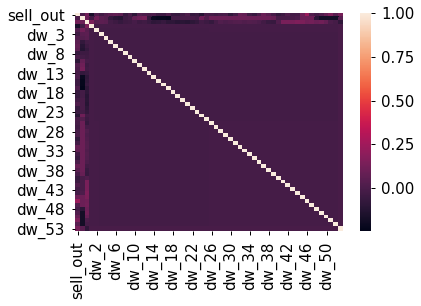

In [76]:
corr_matrix = df[df.columns].corr(method='pearson')
sns.heatmap(corr_matrix);

In [75]:
#################################Linear regresion - ElasticNet/ SVR
#linear = LinearRegression()
#lasso = Lasso()
#ridge = Ridge()
elasticnet = ElasticNet()
#srv = SVR(kernel='rbf',verbose=True) #C=1e3, gamma=0.1


pca1 = PCA(0.95, random_state = RANDOM_STATE)
scaler1 = StandardScaler()
scaler2 = MinMaxScaler(feature_range=(-1, 1))
srv_pipe = Pipeline([   
                        ('pca1',pca1),                    
                        ('scaler1',scaler1),
                        ('scaler2',scaler2),
                        ('poly', PolynomialFeatures(degree=2)),
                        #('linear', linear) 
                        #('lasso', lasso)
                        #('ridge', ridge)
                        ('elasticnet', elasticnet) 
                        #('srv', srv) 
                        
                        
                        
                        ])

srv_pipe_params = {#'srv__C': np.logspace(-0, 6, 4) 
                    #,'srv__gamma': np.logspace(-4, 1, 4) 
                   #,'srv__loss' : ['epsilon_insensitive','squared_epsilon_insensitive']
                    #'srv__kernel: ['rbf', 'linear','poly'] 
                    
                    #'lasso__alpha' : np.logspace(-4, 2, 8) 
                    #'linear__fit_intercept ' : [True,False] 
                    #'ridge__alpha' : np.logspace(0, 4, 4)
                    'elasticnet__alpha' : np.logspace(-1, 10, 20) 
                    ,'elasticnet__l1_ratio' : np.logspace(-2, 1, 4) 
                    }
#svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)
#svr_lin = SVR(kernel='linear', C=1e3)
#svr_poly = SVR(kernel='poly', C=1e3, degree=2)  

model = GridSearchCV(srv_pipe, cv=5, param_grid=srv_pipe_params, scoring='neg_mean_squared_error',verbose=1,n_jobs=-1)
print(X_train.shape)
model.fit(X_train.reshape(-1, X_train.shape[1]*X_train.shape[2]), y_train[:,])
print("Best: %f using %s" % (model.best_score_, model.best_params_))
means = model.cv_results_['mean_test_score']
stds = model.cv_results_['std_test_score']
params = model.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

(197, 4, 5)
Fitting 5 folds for each of 80 candidates, totalling 400 fits
Best: -1129.183394 using {'elasticnet__l1_ratio': 0.1, 'elasticnet__alpha': 1.438449888287663}
-1181.887141 (323.501329) with: {'elasticnet__l1_ratio': 0.01, 'elasticnet__alpha': 0.1}
-1186.798002 (322.832355) with: {'elasticnet__l1_ratio': 0.1, 'elasticnet__alpha': 0.1}
-1634.009402 (496.635618) with: {'elasticnet__l1_ratio': 1.0, 'elasticnet__alpha': 0.1}
-1148.422066 (340.723311) with: {'elasticnet__l1_ratio': 10.0, 'elasticnet__alpha': 0.1}
-1136.503227 (326.982287) with: {'elasticnet__l1_ratio': 0.01, 'elasticnet__alpha': 0.37926901907322497}
-1136.920326 (326.623783) with: {'elasticnet__l1_ratio': 0.1, 'elasticnet__alpha': 0.37926901907322497}
-1302.837401 (317.258871) with: {'elasticnet__l1_ratio': 1.0, 'elasticnet__alpha': 0.37926901907322497}
-1131.682095 (330.284614) with: {'elasticnet__l1_ratio': 10.0, 'elasticnet__alpha': 0.37926901907322497}
-1129.328014 (328.627291) with: {'elasticnet__l1_ratio': 0.

[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    2.9s finished


In [85]:
### model.add(Reshape((-1,X_train.shape[1]*X_train.shape[2]), input_shape=(X_train.shape[1], X_train.shape[2])))
from keras.layers.advanced_activations import LeakyReLU, PReLU,Softmax
from keras import optimizers
#model.add(Reshape((-1,X_train.shape[1]*X_train.shape[2]), input_shape=(X_train.shape[1], X_train.shape[2])))

model = Sequential()

model.add(LSTM(7,input_shape=(X_train.shape[1], X_train.shape[2]),return_sequences=True,kernel_initializer='glorot_uniform')) 
#model.add(Activation("relu")) 
model.add(LeakyReLU(alpha=.001))   

model.add(Dense(72,kernel_initializer='glorot_uniform')) 
model.add(LeakyReLU(alpha=.001))   

model.add(LSTM(10,return_sequences=False,kernel_initializer='glorot_uniform')) 
model.add(LeakyReLU(alpha=.001))   

model.add(Dense(1024,kernel_initializer='glorot_uniform')) 
model.add(Softmax(axis=-1))
model.add(Dropout(0.5))

model.add(Dense(100,kernel_initializer='glorot_uniform')) 
model.add(Activation("relu"))

model.add(Dense(1))

model.compile(loss="mean_squared_error", optimizer=optimizers.RMSprop(lr=0.001, rho=0.5, epsilon=0.05, decay=0.0))
model.fit(X_train, y_train, batch_size=500, nb_epoch=500, validation_data=(X_test, y_test)) #validation_split=0.3

Train on 194 samples, validate on 83 samples
Epoch 1/500
194/194 [==============================] - 2s 11ms/step - loss: 1669500.2500 - val_loss: 2081247.2500
Epoch 2/500
194/194 [==============================] - 0s 283us/step - loss: 1669457.6250 - val_loss: 2081196.8750
Epoch 3/500
194/194 [==============================] - 0s 236us/step - loss: 1669414.0000 - val_loss: 2081148.5000
Epoch 4/500
194/194 [==============================] - 0s 210us/step - loss: 1669372.2500 - val_loss: 2081102.2500
Epoch 5/500
194/194 [==============================] - 0s 256us/step - loss: 1669331.2500 - val_loss: 2081056.7500
Epoch 6/500
194/194 [==============================] - 0s 232us/step - loss: 1669292.0000 - val_loss: 2081011.5000
Epoch 7/500
194/194 [==============================] - 0s 267us/step - loss: 1669251.7500 - val_loss: 2080965.7500
Epoch 8/500
194/194 [==============================] - 0s 288us/step - loss: 1669211.8750 - val_loss: 2080919.7500
Epoch 9/500
194/194 [===============

Epoch 72/500
194/194 [==============================] - 0s 296us/step - loss: 1665534.0000 - val_loss: 2076681.6250
Epoch 73/500
194/194 [==============================] - 0s 239us/step - loss: 1665463.8750 - val_loss: 2076594.8750
Epoch 74/500
194/194 [==============================] - 0s 272us/step - loss: 1665387.3750 - val_loss: 2076508.0000
Epoch 75/500
194/194 [==============================] - 0s 232us/step - loss: 1665308.5000 - val_loss: 2076420.2500
Epoch 76/500
194/194 [==============================] - 0s 221us/step - loss: 1665235.7500 - val_loss: 2076332.1250
Epoch 77/500
194/194 [==============================] - 0s 242us/step - loss: 1665156.6250 - val_loss: 2076243.1250
Epoch 78/500
194/194 [==============================] - 0s 263us/step - loss: 1665077.7500 - val_loss: 2076153.6250
Epoch 79/500
194/194 [==============================] - 0s 265us/step - loss: 1665002.8750 - val_loss: 2076063.2500
Epoch 80/500
194/194 [==============================] - 0s 240us/step - 

Epoch 143/500
194/194 [==============================] - 0s 272us/step - loss: 1658845.0000 - val_loss: 2068984.1250
Epoch 144/500
194/194 [==============================] - 0s 231us/step - loss: 1658709.6250 - val_loss: 2068852.6250
Epoch 145/500
194/194 [==============================] - 0s 254us/step - loss: 1658596.7500 - val_loss: 2068720.6250
Epoch 146/500
194/194 [==============================] - 0s 217us/step - loss: 1658494.3750 - val_loss: 2068588.3750
Epoch 147/500
194/194 [==============================] - 0s 258us/step - loss: 1658366.8750 - val_loss: 2068455.1250
Epoch 148/500
194/194 [==============================] - 0s 241us/step - loss: 1658269.0000 - val_loss: 2068321.5000
Epoch 149/500
194/194 [==============================] - 0s 221us/step - loss: 1658134.3750 - val_loss: 2068187.1250
Epoch 150/500
194/194 [==============================] - 0s 226us/step - loss: 1658017.5000 - val_loss: 2068052.0000
Epoch 151/500
194/194 [==============================] - 0s 244u

194/194 [==============================] - 0s 269us/step - loss: 1649519.1250 - val_loss: 2058298.0000
Epoch 214/500
194/194 [==============================] - 0s 228us/step - loss: 1649406.0000 - val_loss: 2058123.6250
Epoch 215/500
194/194 [==============================] - 0s 263us/step - loss: 1649255.6250 - val_loss: 2057948.3750
Epoch 216/500
194/194 [==============================] - 0s 250us/step - loss: 1649111.1250 - val_loss: 2057772.7500
Epoch 217/500
194/194 [==============================] - 0s 232us/step - loss: 1648911.1250 - val_loss: 2057596.1250
Epoch 218/500
194/194 [==============================] - 0s 245us/step - loss: 1648762.7500 - val_loss: 2057419.0000
Epoch 219/500
194/194 [==============================] - 0s 229us/step - loss: 1648624.3750 - val_loss: 2057241.2500
Epoch 220/500
194/194 [==============================] - 0s 247us/step - loss: 1648468.6250 - val_loss: 2057063.0000
Epoch 221/500
194/194 [==============================] - 0s 275us/step - loss:

Epoch 284/500
194/194 [==============================] - 0s 278us/step - loss: 1637384.7500 - val_loss: 2044364.1250
Epoch 285/500
194/194 [==============================] - 0s 286us/step - loss: 1637208.8750 - val_loss: 2044145.7500
Epoch 286/500
194/194 [==============================] - 0s 248us/step - loss: 1637101.0000 - val_loss: 2043926.7500
Epoch 287/500
194/194 [==============================] - 0s 295us/step - loss: 1636815.3750 - val_loss: 2043707.1250
Epoch 288/500
194/194 [==============================] - 0s 257us/step - loss: 1636674.0000 - val_loss: 2043486.8750
Epoch 289/500
194/194 [==============================] - 0s 231us/step - loss: 1636426.2500 - val_loss: 2043265.5000
Epoch 290/500
194/194 [==============================] - 0s 252us/step - loss: 1636305.0000 - val_loss: 2043044.3750
Epoch 291/500
194/194 [==============================] - 0s 240us/step - loss: 1636057.8750 - val_loss: 2042822.0000
Epoch 292/500
194/194 [==============================] - 0s 274u

194/194 [==============================] - 0s 262us/step - loss: 1622825.3750 - val_loss: 2027577.0000
Epoch 355/500
194/194 [==============================] - 0s 218us/step - loss: 1622305.1250 - val_loss: 2027314.5000
Epoch 356/500
194/194 [==============================] - 0s 264us/step - loss: 1622280.8750 - val_loss: 2027052.8750
Epoch 357/500
194/194 [==============================] - 0s 231us/step - loss: 1622034.1250 - val_loss: 2026790.1250
Epoch 358/500
194/194 [==============================] - 0s 256us/step - loss: 1621736.8750 - val_loss: 2026525.8750
Epoch 359/500
194/194 [==============================] - 0s 269us/step - loss: 1621621.1250 - val_loss: 2026262.3750
Epoch 360/500
194/194 [==============================] - 0s 227us/step - loss: 1621360.5000 - val_loss: 2025997.5000
Epoch 361/500
194/194 [==============================] - 0s 271us/step - loss: 1621139.0000 - val_loss: 2025732.0000
Epoch 362/500
194/194 [==============================] - 0s 296us/step - loss:

Epoch 425/500
194/194 [==============================] - 0s 287us/step - loss: 1605154.7500 - val_loss: 2007489.3750
Epoch 426/500
194/194 [==============================] - 0s 277us/step - loss: 1605038.6250 - val_loss: 2007185.5000
Epoch 427/500
194/194 [==============================] - 0s 273us/step - loss: 1604798.8750 - val_loss: 2006881.1250
Epoch 428/500
194/194 [==============================] - 0s 266us/step - loss: 1604359.2500 - val_loss: 2006574.8750
Epoch 429/500
194/194 [==============================] - 0s 258us/step - loss: 1604316.2500 - val_loss: 2006268.8750
Epoch 430/500
194/194 [==============================] - 0s 312us/step - loss: 1604210.2500 - val_loss: 2005962.7500
Epoch 431/500
194/194 [==============================] - 0s 298us/step - loss: 1603438.5000 - val_loss: 2005654.0000
Epoch 432/500
194/194 [==============================] - 0s 260us/step - loss: 1603482.2500 - val_loss: 2005346.1250
Epoch 433/500
194/194 [==============================] - 0s 269u

194/194 [==============================] - 0s 280us/step - loss: 1585610.3750 - val_loss: 1984720.7500
Epoch 496/500
194/194 [==============================] - 0s 324us/step - loss: 1585109.1250 - val_loss: 1984374.7500
Epoch 497/500
194/194 [==============================] - 0s 305us/step - loss: 1584730.0000 - val_loss: 1984027.7500
Epoch 498/500
194/194 [==============================] - 0s 321us/step - loss: 1584328.6250 - val_loss: 1983679.0000
Epoch 499/500
194/194 [==============================] - 0s 353us/step - loss: 1584139.0000 - val_loss: 1983331.2500
Epoch 500/500
194/194 [==============================] - 0s 408us/step - loss: 1584059.5000 - val_loss: 1982983.0000


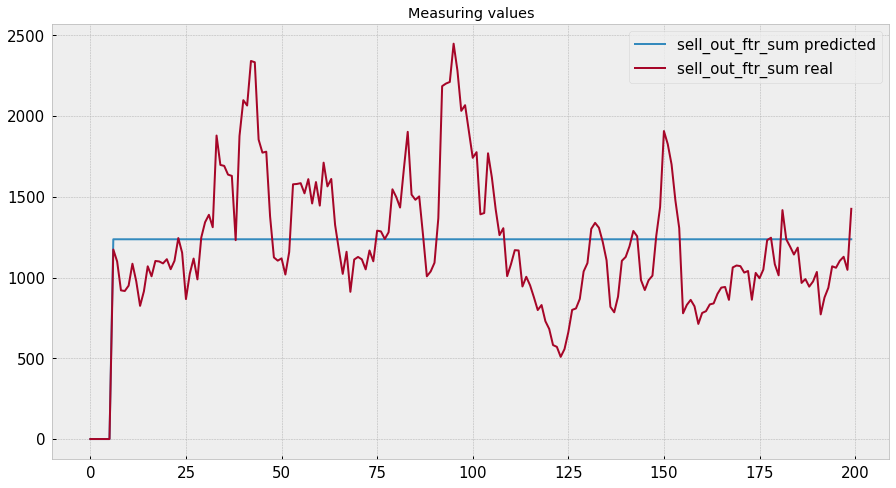

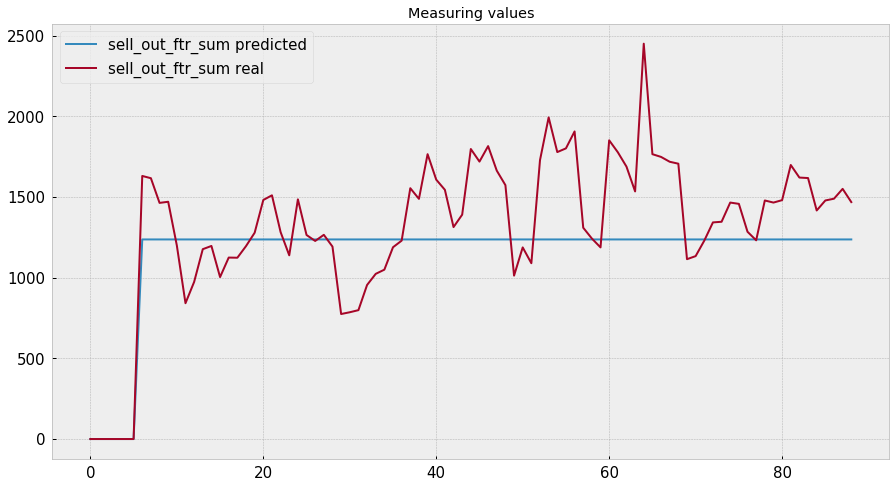

In [84]:
#Для температуры газа
plot_predicted(X_train,y_train,model,range_low = 0,range_high=1)
plot_predicted(X_test,y_test,model,range_low = 0,range_high=1)
#plot_predicted(X_test_1,y_test_1,model,range_low = 0,range_high=1)


In [106]:
data_cut = data_a1[(data_a1['item_id']==9391402)&(data_a1['house_id']==2100)].groupby('date_week_long',as_index = False).max()
data_cut['']

,date_week_long,trans_id,date,sell_big,house_id,item_id,date_dayweek,date_month,date_year,date_month_long,sell_out,sell_in,rest,wdperw
0,104,561.0,2012-12-31,20,2100,9391402,0,12,2012,24,0,20,26,0
1,105,602.0,2013-01-10,2,2100,9391402,3,1,2013,25,2,2,26,3
2,106,601.0,2013-01-15,20,2100,9391402,1,1,2013,25,2,20,42,5
3,108,601.0,2013-02-01,20,2100,9391402,4,2,2013,26,12,20,52,5
4,109,601.0,2013-02-06,-6,2100,9391402,2,2,2013,26,6,0,46,5
5,110,602.0,2013-02-11,6,2100,9391402,0,2,2013,26,6,6,52,5
6,111,601.0,2013-02-20,20,2100,9391402,2,2,2013,26,6,20,56,5
7,112,601.0,2013-02-26,-8,2100,9391402,1,2,2013,26,8,0,44,5
8,114,601.0,2013-03-14,-4,2100,9391402,3,3,2013,27,6,0,40,5
9,115,601.0,2013-03-22,20,2100,9391402,4,3,2013,27,4,20,48,5


AVS HK TIP-ON, Cиловой мех-м  20K2701T
TBX, Напр. с BM, 30 кг, 350 мм, лев. NEW
CLIP top BM, Петля п/фальш вкл 79B9550


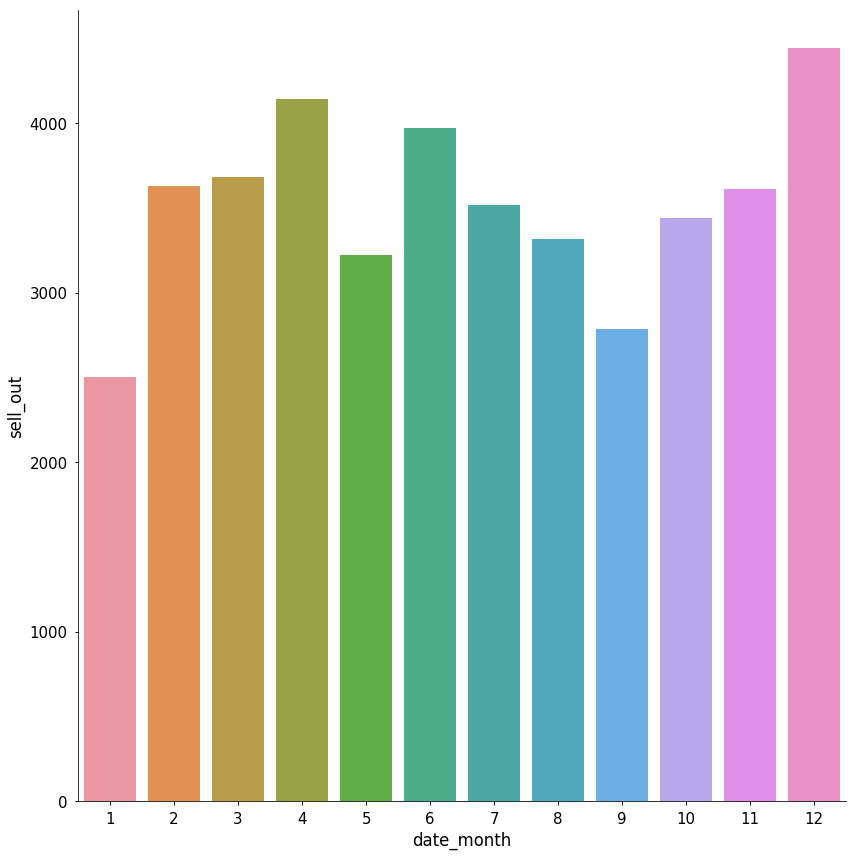

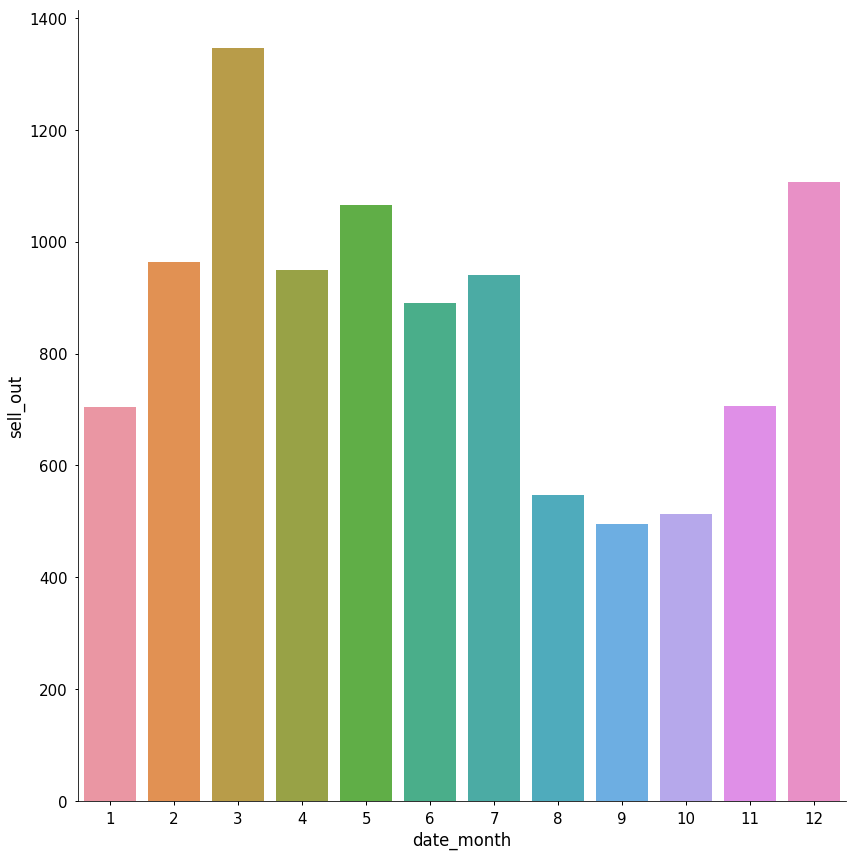

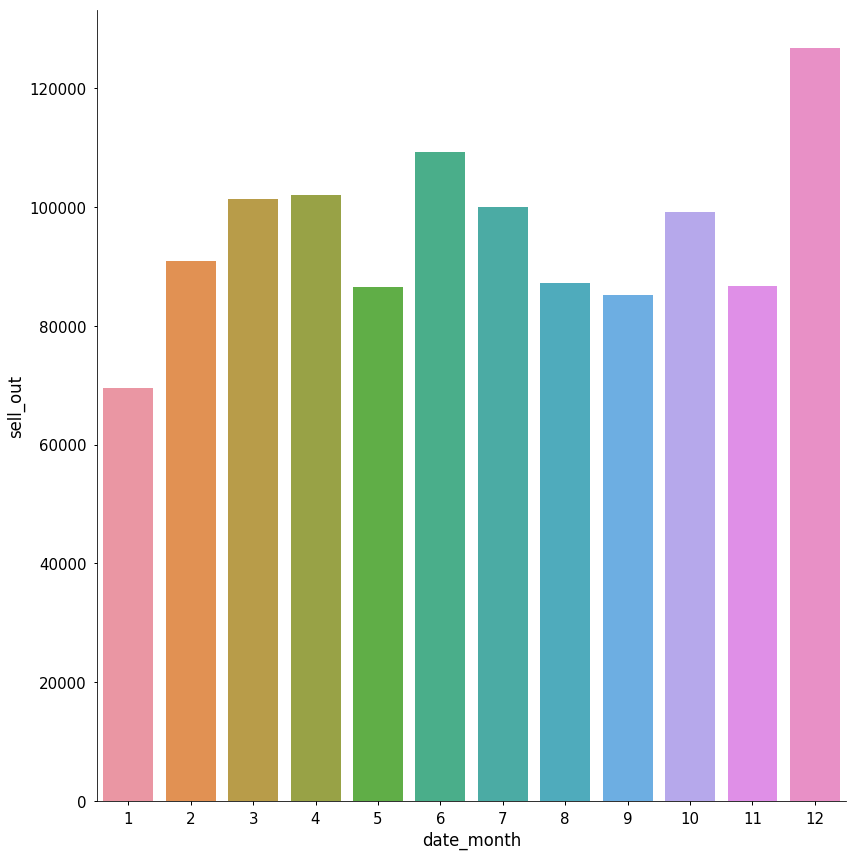

In [10]:
#Продажи по месяцам по продуктам
for k in item_vocab:
    y = data_a1[data_a1['item_id']==k].groupby('date_month',as_index = False)['sell_out'].sum()
    print(item_vocab[k])
    fig = sns.factorplot(x='date_month', y='sell_out', 
               data=y, kind='bar', size=12)
    fig.savefig('date_month.png', bbox_inches='tight')

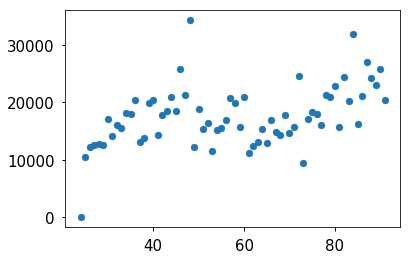

In [11]:
y = data_a1.groupby('date_month_long').sum()
plt.scatter(y.index, y['sell_out'])


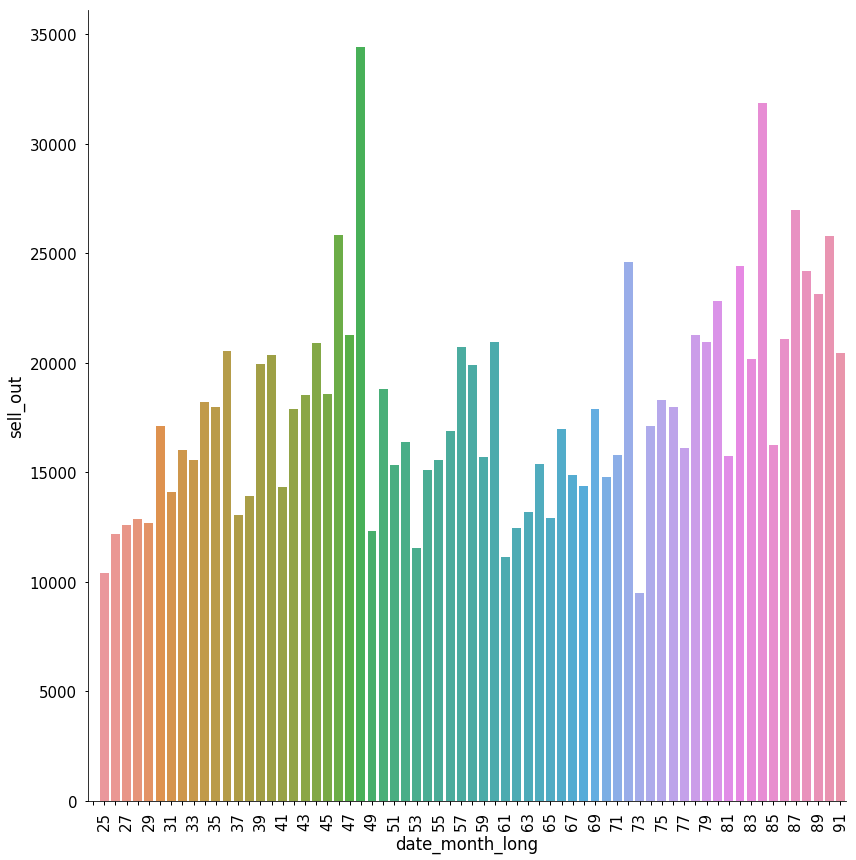

In [12]:
y = data_a1.groupby('date_month_long',as_index = False).sum()
fig = sns.factorplot(x='date_month_long', y='sell_out', 
               data=y, kind='bar', size=12)
#labels = ax.get_xticklabels() # get x labels

for ax in fig.axes.flat:
    labels = ax.get_xticklabels() # get x labels
    for i,l in enumerate(labels):
        if(i%2 == 0): labels[i] = '' # skip even labels
    ax.set_xticklabels(labels, rotation=90) # set new labels
fig.savefig('date_month_long.png', bbox_inches='tight')

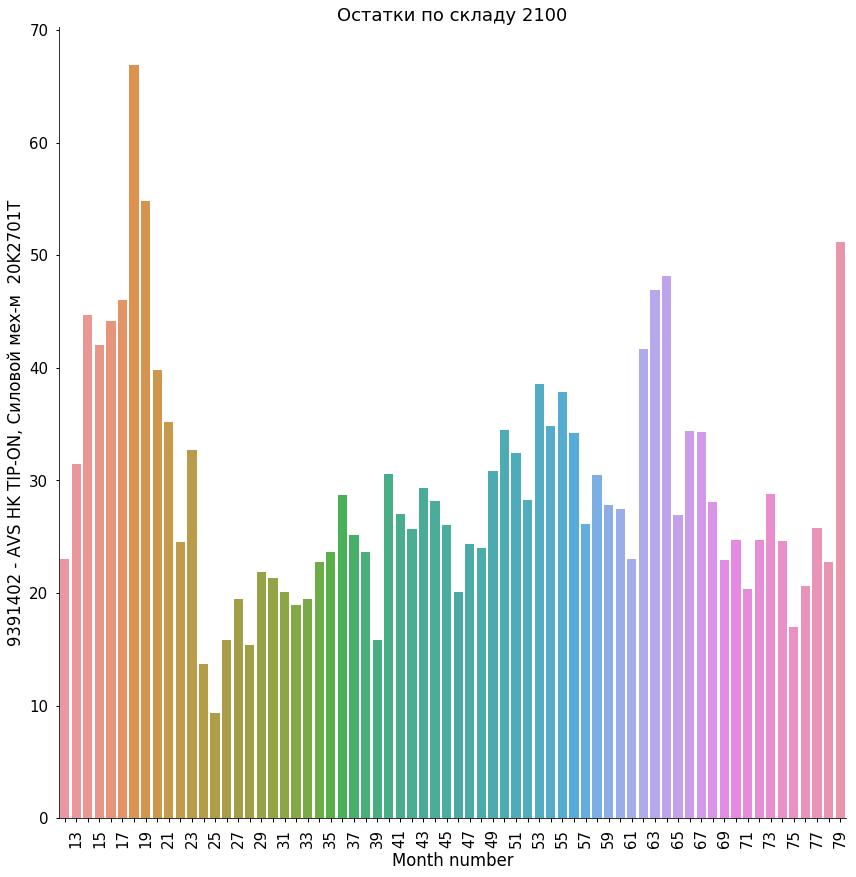

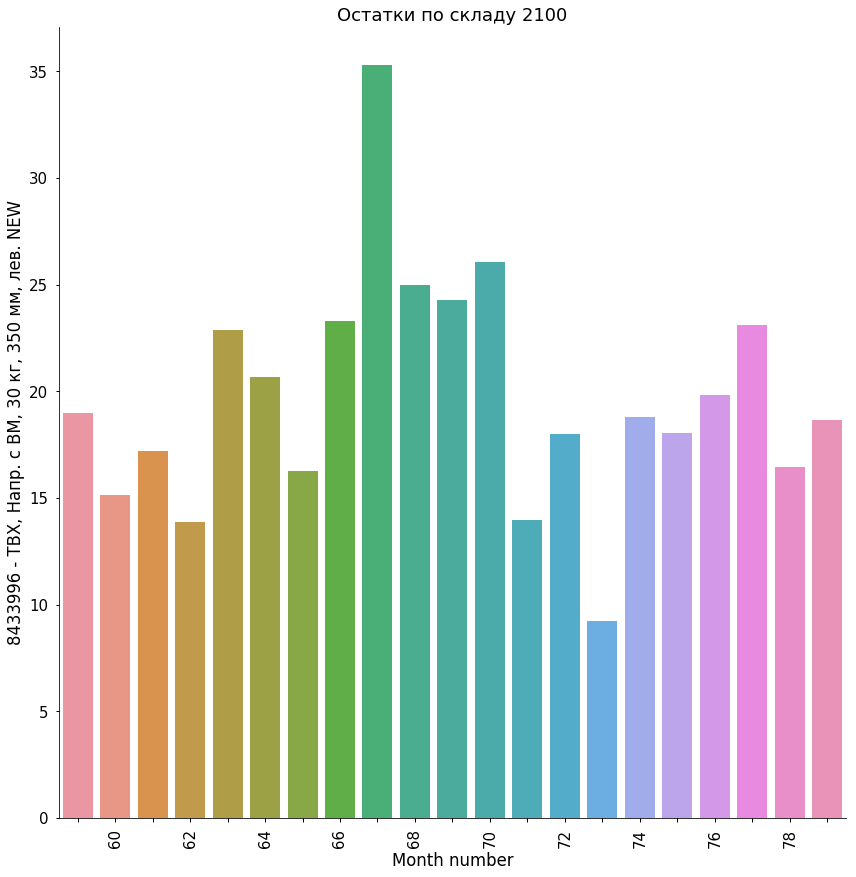

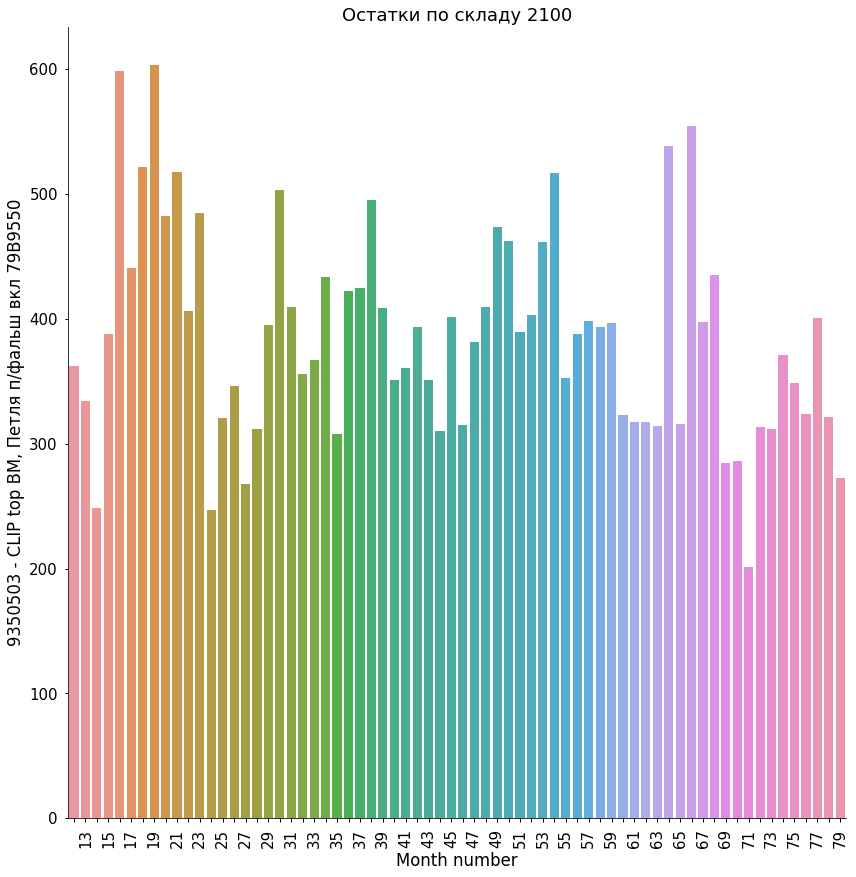

In [93]:
#rest items by house id
sel_h_id = 2100
for k in item_vocab:
    y = data_a1[(data_a1['item_id']==k)&(data_a1['house_id']==sel_h_id)].groupby('date_month_long',as_index = False)['rest'].mean()
    fig = sns.factorplot(x='date_month_long', y='rest', 
               data=y, kind='bar', size=12)
    fig.set_axis_labels("Month number", "%s - %s"%(k,item_vocab[k]))
    for ax in fig.axes.flat:
        labels = ax.get_xticklabels() # get x labels
        ax.set_title("Остатки по складу %s"%sel_h_id)
        for i,l in enumerate(labels):
            if(i%2 == 0): labels[i] = '' # skip even labels
        ax.set_xticklabels(labels, rotation=90) # set new labels
    fig.savefig('rest_by_month_%s_%s.png'%(sel_h_id,k), bbox_inches='tight')

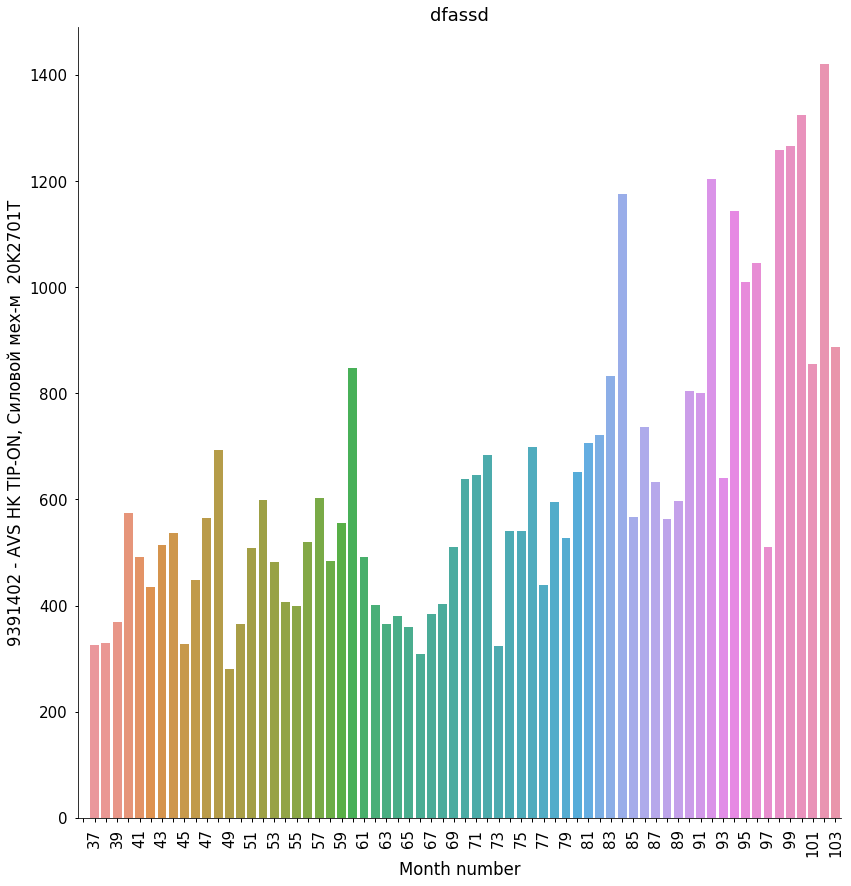

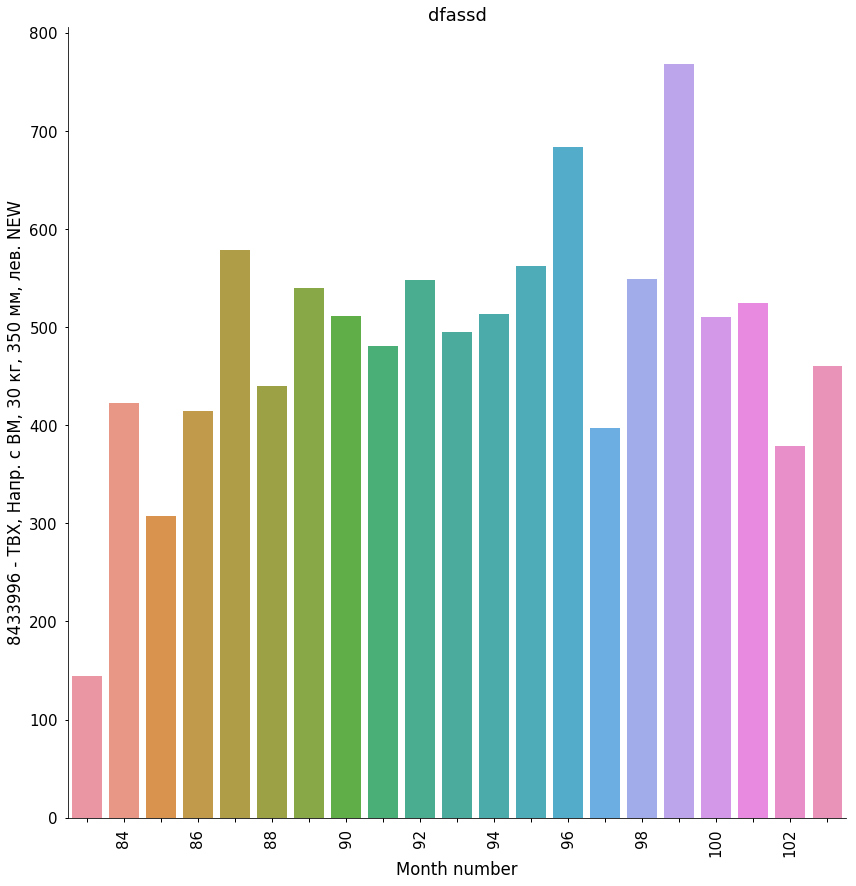

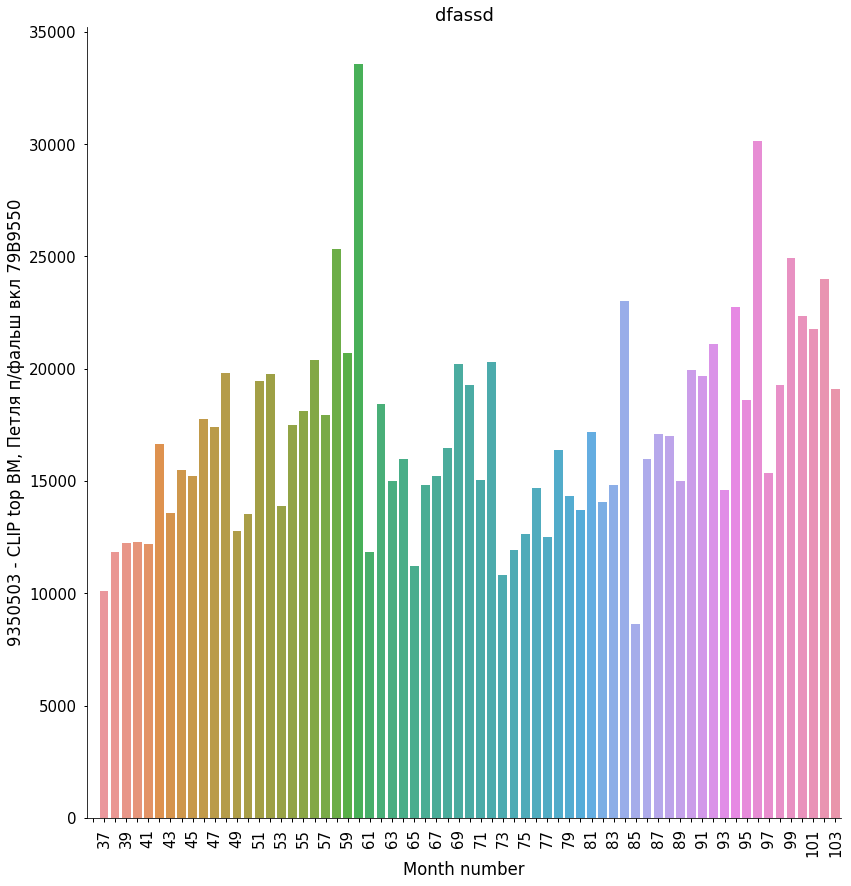

In [204]:
#sell_out by items
for k in item_vocab:
    y = data_a1[data_a1['item_id']==k].groupby('date_month_long',as_index = False)['sell_out'].sum()
    fig = sns.factorplot(x='date_month_long', y='sell_out', 
               data=y, kind='bar', size=12)
    fig.set_axis_labels("Month number", "%s - %s"%(k,item_vocab[k]))
    for ax in fig.axes.flat:
        labels = ax.get_xticklabels() # get x labels
        ax.set_title("Заголовок")
        for i,l in enumerate(labels):
            if(i%2 == 0): labels[i] = '' # skip even labels
        ax.set_xticklabels(labels, rotation=90) # set new labels
    fig.savefig('date_month_long_%s.png'%k, bbox_inches='tight')

KeyError: 'sell_out'

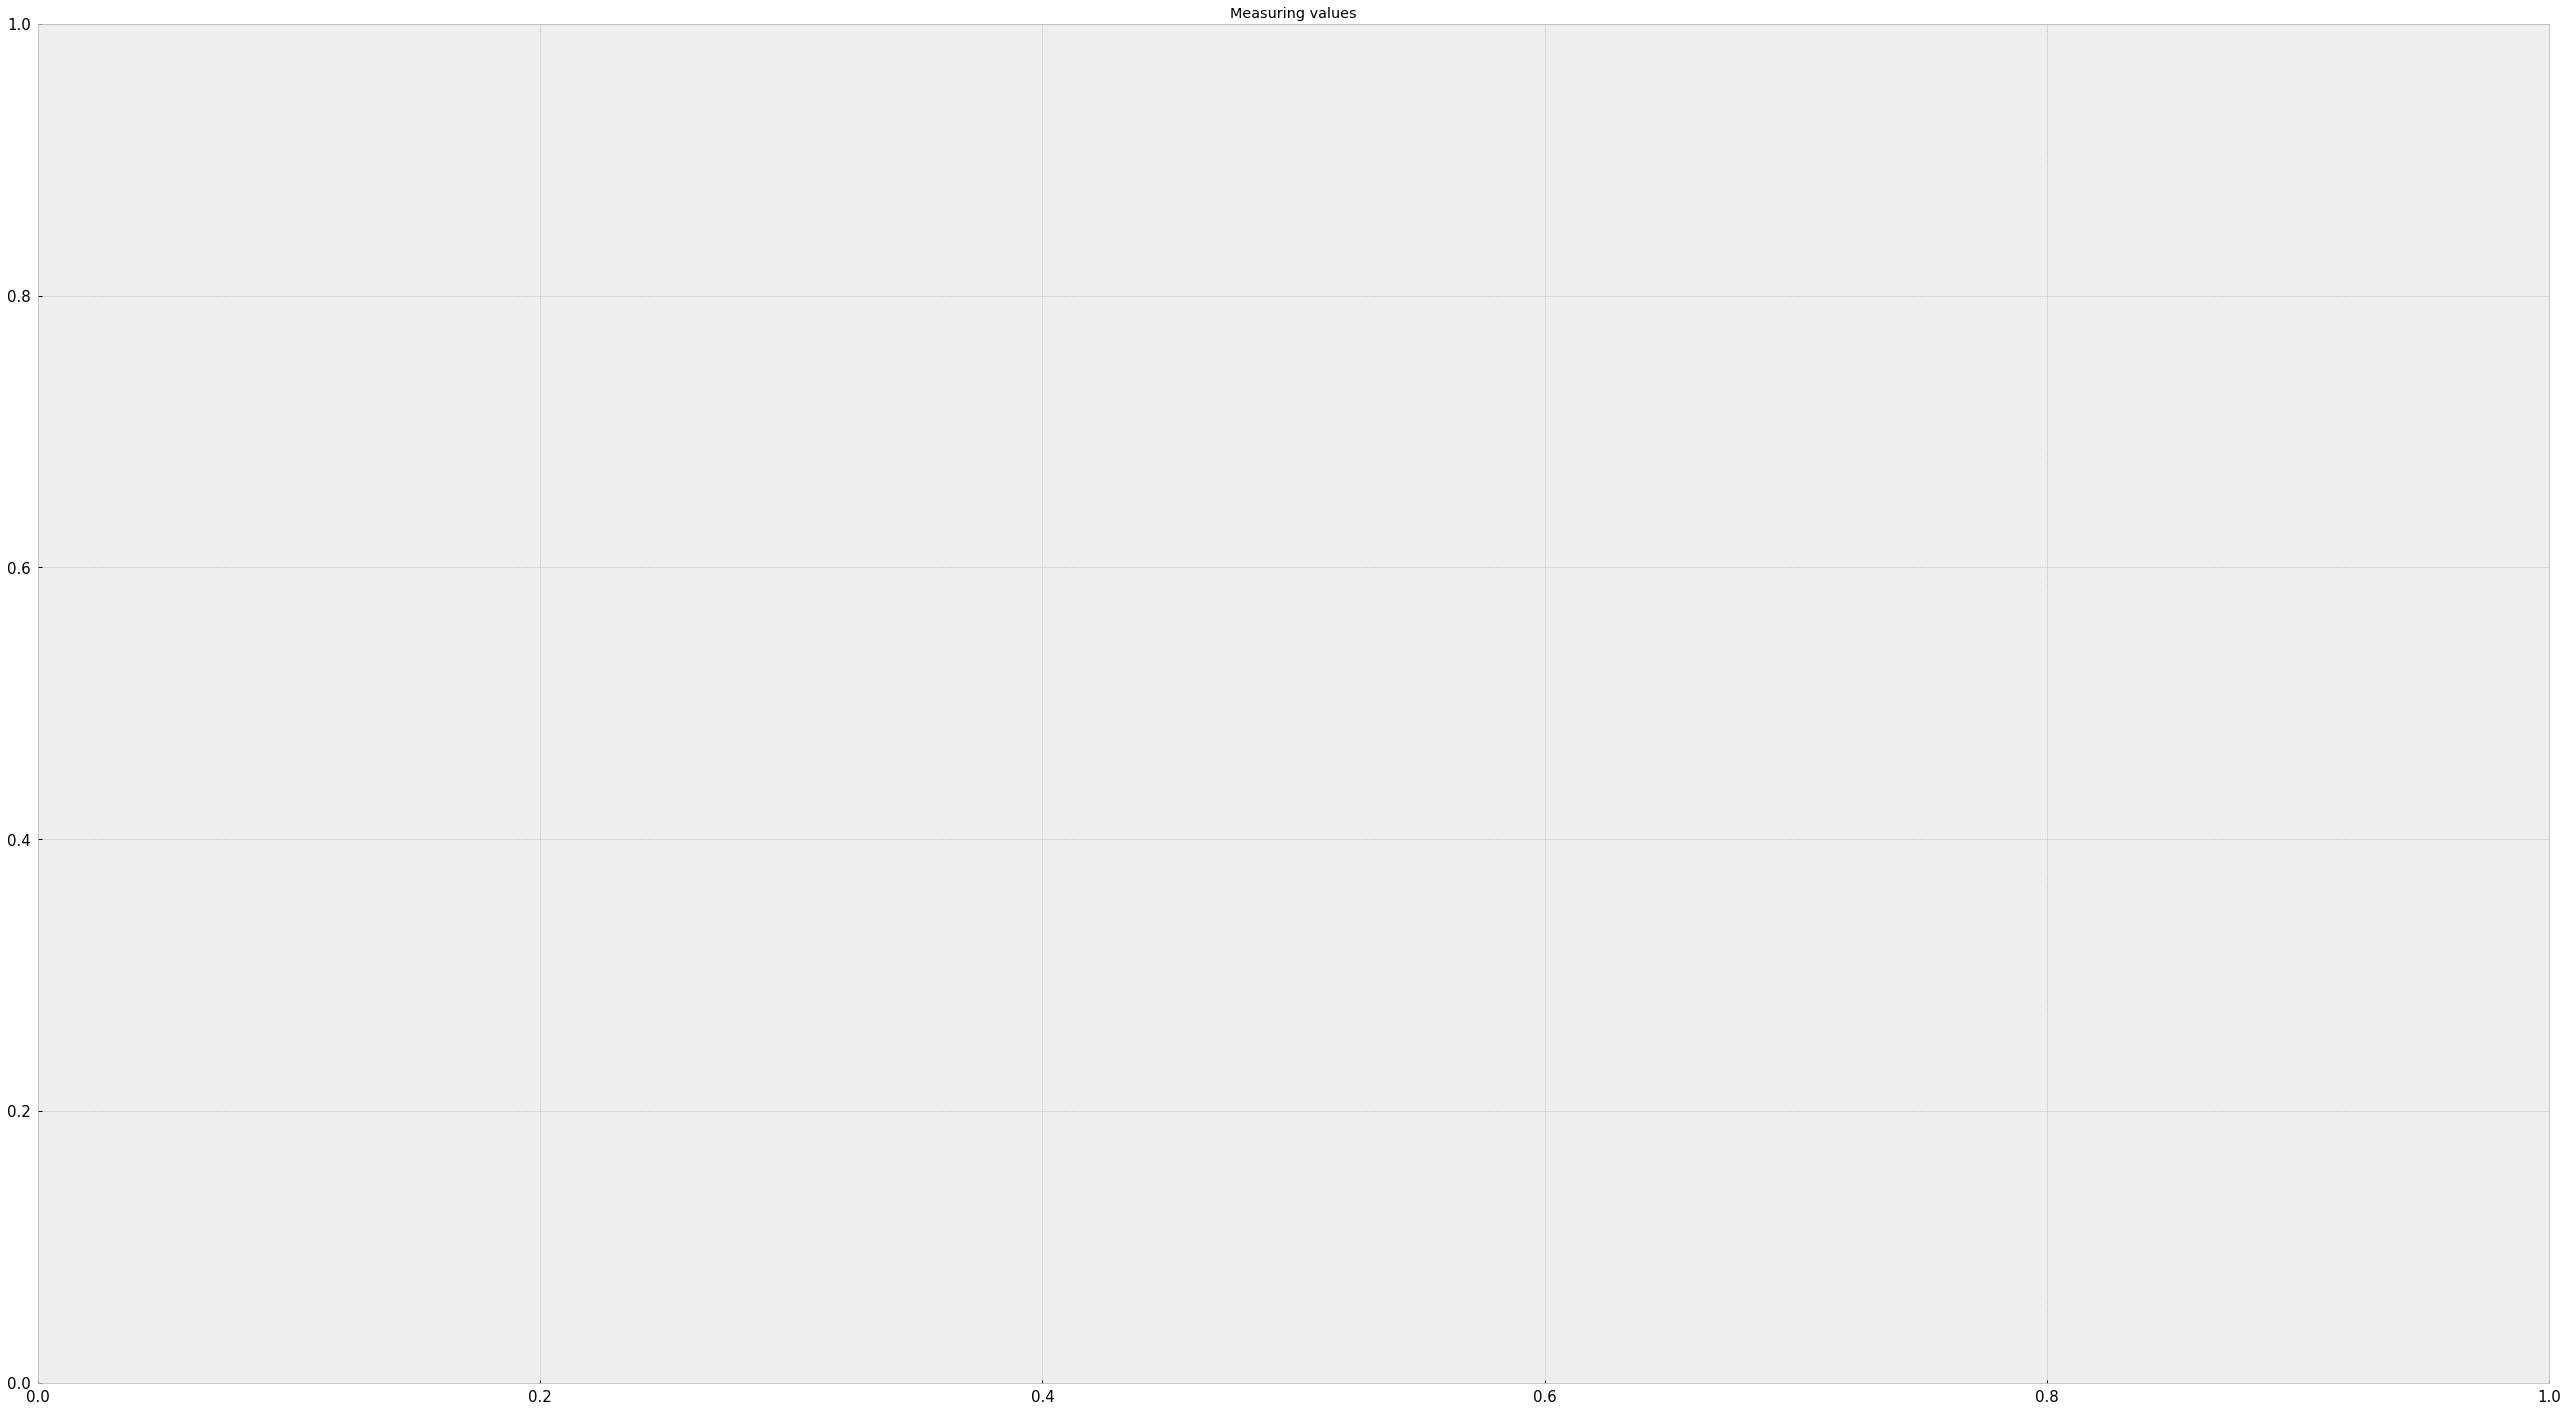

In [96]:
#rest items by house id
sel_h_id = 2100
for k in item_vocab:
    y = data_a1[(data_a1['item_id']==k)&(data_a1['house_id']==sel_h_id)].groupby('date_week_long',as_index = False)['rest'].mean()
    with plt.style.context('bmh'):    
        fig = plt.figure(figsize=(45, 25))
        plt.title('Measuring values')
        plt.plot(y['date_week_long'],y['sell_out'],label='sell_out - %s'%house_vocab[sel_h_id])
        plt.plot(y['date_week_long'],y['sell_in'],label='sell_in - %s'%house_vocab[sel_h_id])
        plt.legend(loc="best")
    fig.savefig('date_month_long.house_id.png', bbox_inches='tight')
    

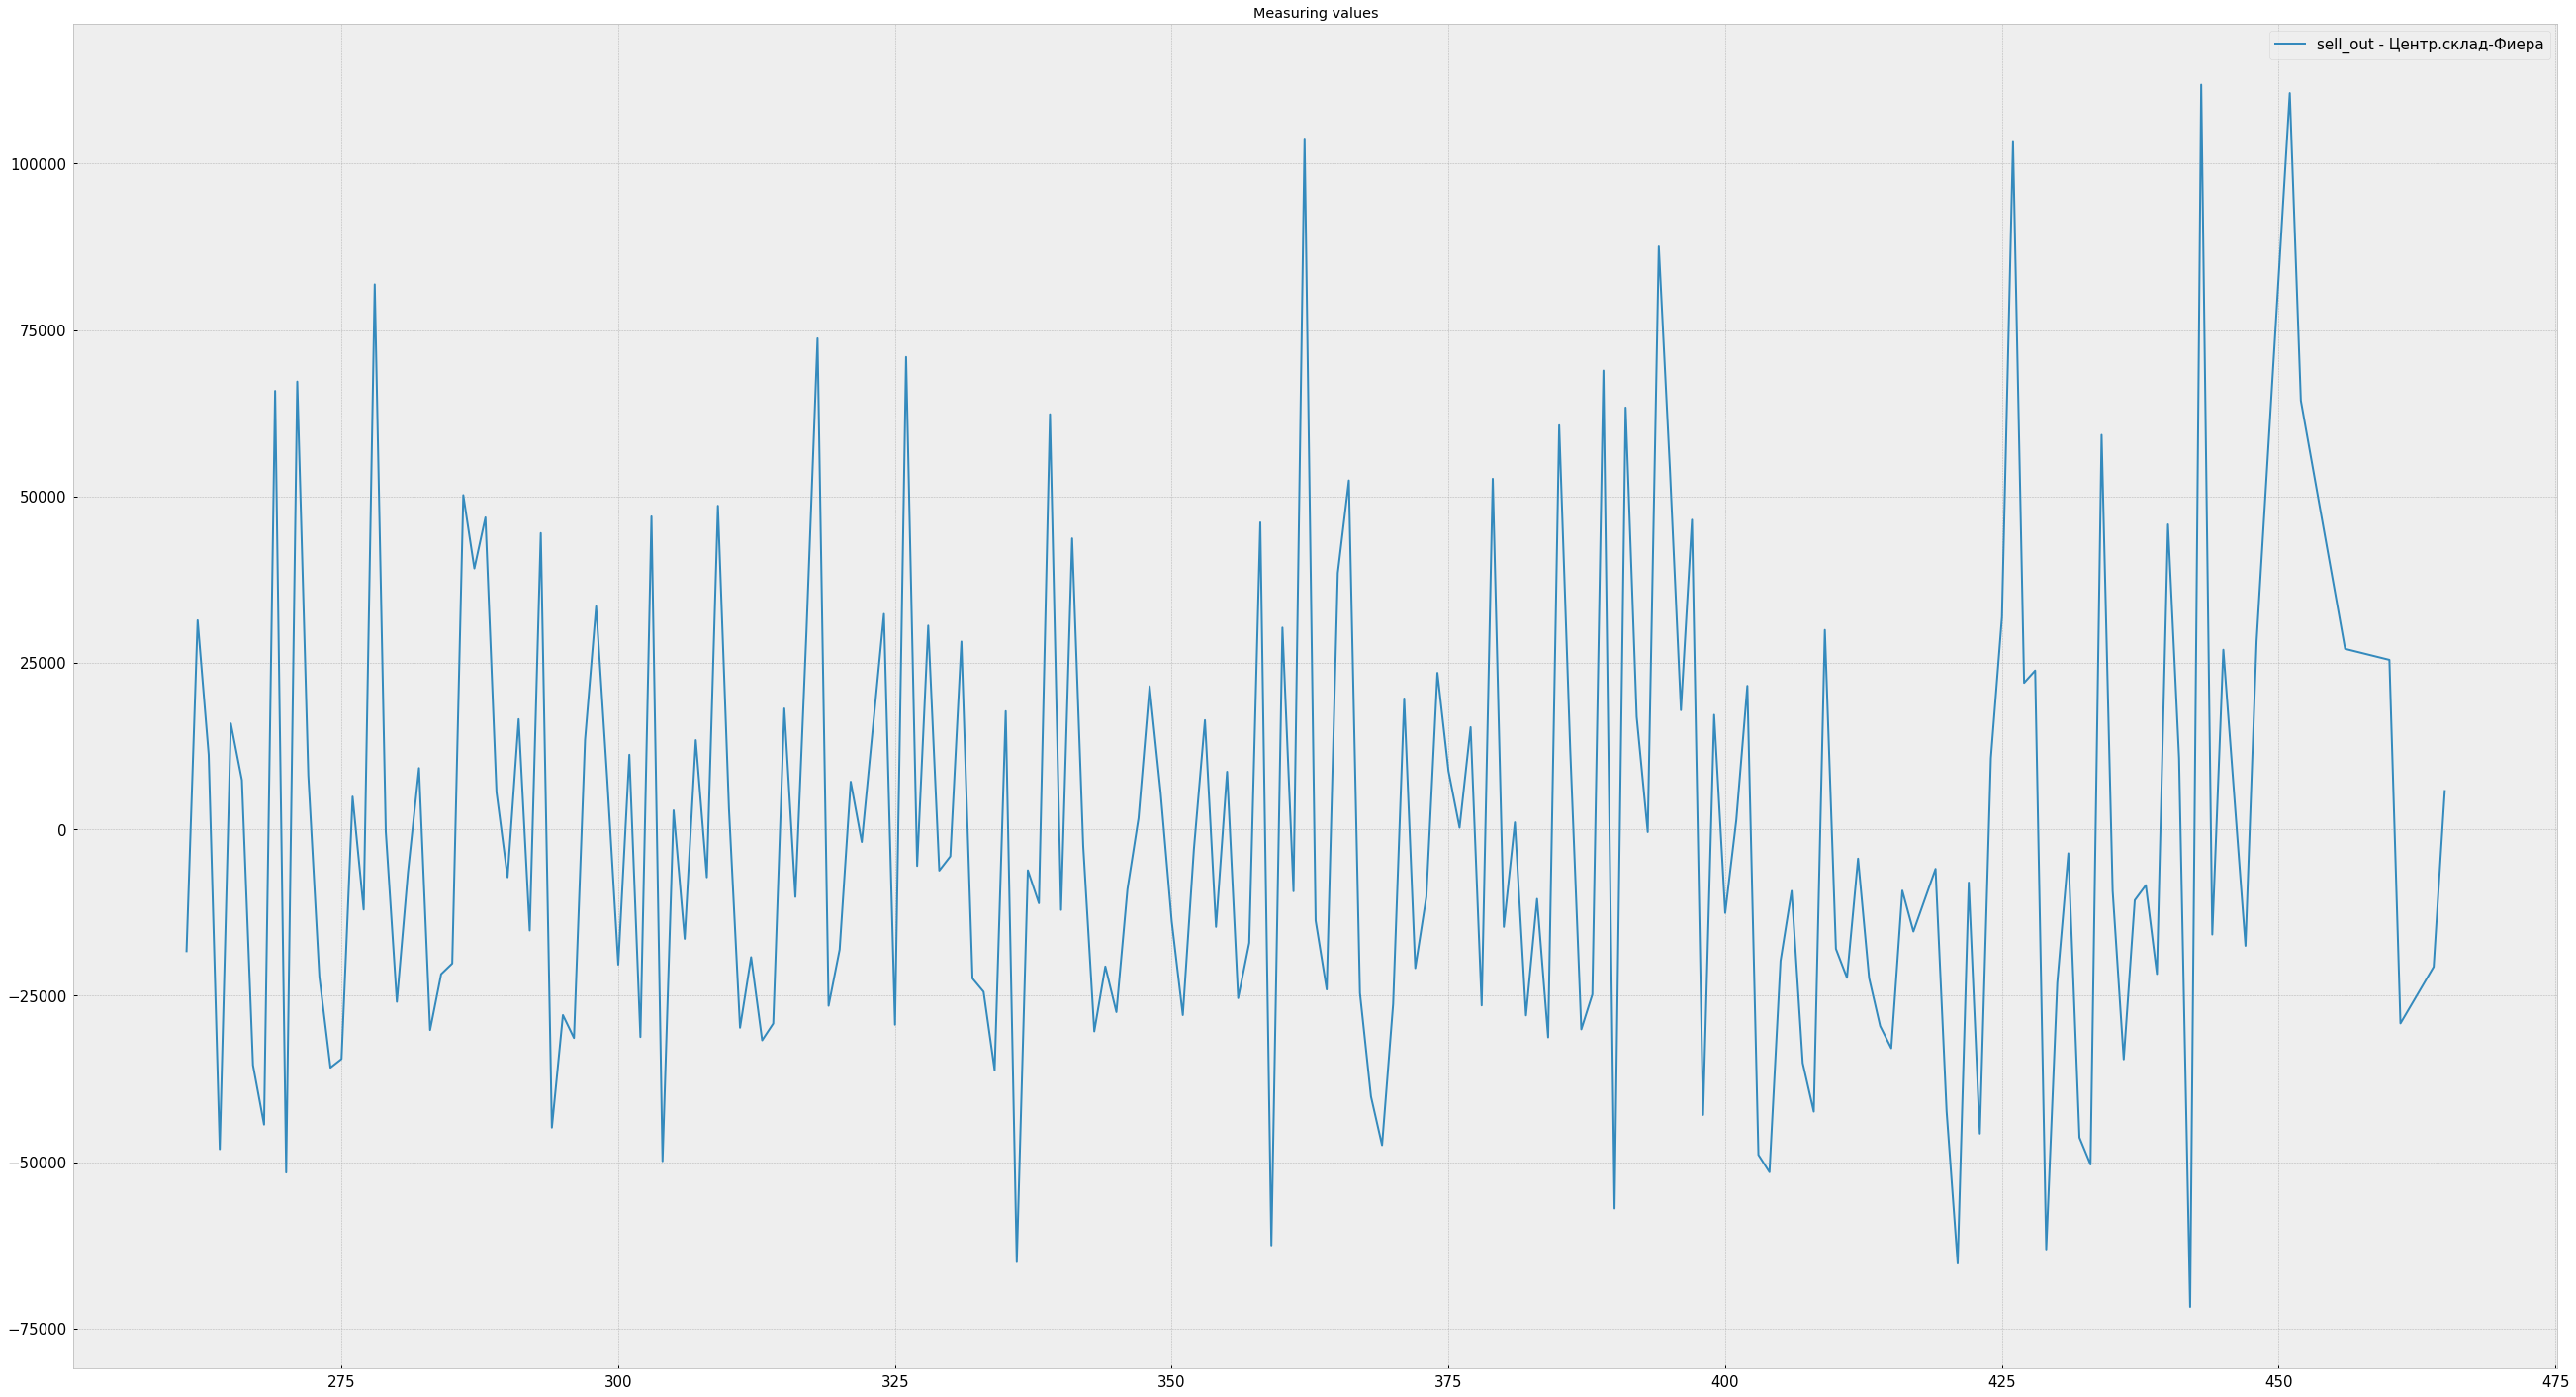

In [23]:
d_temp = data_a1[data_a1['house_id']==1100]
d_temp['sell_out'] = d_temp['sell_in']-d_temp['sell_out']
y = d_temp.groupby(['date_week_long','house_id'],as_index = False).sum()
with plt.style.context('bmh'):    
    fig = plt.figure(figsize=(45, 25))
    plt.title('Measuring values')
    for k in y['house_id'].unique():
        plt.plot(y[y['house_id']==k]['date_week_long'],y[y['house_id']==k]['sell_out'],label='sell_out - %s'%house_vocab[k])
        #plt.plot(y[y['house_id']==k]['date_month_long'],y[y['house_id']==k]['sell_in'],label='sell_in - %s'%house_vocab[k])
    plt.legend(loc="best")
fig.savefig('date_week_long.house_id.png', bbox_inches='tight')

In [14]:
y = data_a1.groupby(['date_month_long','house_id'],as_index = False).sum()
y[y['house_id']==2200].describe()

,date_month_long,house_id,trans_id,sell_big,item_id,date_dayweek,date_month,date_year,sell_out,sell_in
count,48.00,48.0,48.000000,48.000000,4.800000e+01,48.000000,48.000000,4.800000e+01,48.000000,48.000000
mean,84.50,2200.0,616068.833333,-211.729167,5.483908e+09,2417.520833,6706.458333,2.083214e+06,12699.562500,12487.833333
std,14.00,0.0,192936.587473,3955.129913,1.724471e+09,737.234250,4772.556917,6.525626e+05,4001.224759,5532.649726
min,61.00,2200.0,111642.000000,-9116.000000,9.188690e+08,666.000000,878.000000,3.793840e+05,1556.000000,25.000000
25%,72.75,2200.0,594920.000000,-2500.500000,5.309362e+09,2186.000000,2964.750000,2.019277e+06,12299.000000,9411.000000
50%,84.50,2200.0,656356.000000,-218.500000,5.848781e+09,2523.000000,5822.500000,2.217140e+06,13332.000000,12322.000000
75%,96.25,2200.0,719088.750000,2394.500000,6.355202e+09,2919.000000,9840.000000,2.432397e+06,14640.000000,16206.750000
max,108.00,2200.0,897610.000000,8772.000000,8.025116e+09,3595.000000,18072.000000,3.037602e+06,19513.000000,21828.000000


In [245]:
date1 = date(2010, 6, 25)
date2 = date(2010, 7, 2)
date_delta = abs(date1-date2)
date_delta.days//7
type(date1)

datetime.date